In [3]:
import cv2
import numpy as np

def detect_and_crop_mrz(image_path, save_path=None):
    """
    Detect MRZ region in passport and crop it.
    
    Parameters:
        image_path (str): Path to input passport image.
        save_path (str, optional): Path to save cropped MRZ.
    
    Returns:
        mrz_crop (numpy.ndarray): Cropped MRZ image.
    """
    # Read image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found at {image_path}")

    # 1. Noise reduction
    denoised = cv2.medianBlur(img, 3)

    # 2. Edge detection
    edges = cv2.Canny(denoised, 100, 200)

    # 3. Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mrz_crop = None
    height, width = img.shape

    # 4. Loop through contours to find likely MRZ
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h
        if aspect_ratio > 5 and y > height * 0.6:  # MRZ is wide & near bottom
            mrz_crop = img[y:y+h, x:x+w]
            break

    if mrz_crop is None:
        raise ValueError("MRZ region not detected")

    # Save if requested
    if save_path:
        cv2.imwrite(save_path, mrz_crop)

    return mrz_crop

# Example usage
if __name__ == "__main__":
    mrz = detect_and_crop_mrz("templates/Armenia Passport-1.jpg", "templates/Armenia Passport-1_mrz.jpg")

    cv2.imshow("MRZ", mrz)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [1]:
import cv2
import numpy as np
import re

try:
    import pytesseract
    TESSERACT_AVAILABLE = True
except Exception:
    TESSERACT_AVAILABLE = False

MRZ_REGEX = re.compile(r'^[A-Z0-9<]{10,44}$')

def is_mrz_like(text):
    if not text:
        return False
    lines = [re.sub(r'[^A-Z0-9<]', '', ln.upper()) for ln in text.splitlines() if ln.strip()]
    if len(lines) < 2:
        return False
    candidate_lines = [ln for ln in lines if 10 <= len(ln) <= 44]
    if len(candidate_lines) < 2:
        return False
    checks = sum(1 for ln in candidate_lines[:2] if MRZ_REGEX.match(ln))
    return checks >= 1

def order_points_clockwise(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_warp(image, pts, dst_w=None, dst_h=None):
    rect = order_points_clockwise(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB)) if dst_w is None else dst_w
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB)) if dst_h is None else dst_h
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def merge_contours_points(contours):
    """Concatenate all contour points into one Nx1x2 array like cv2 contours"""
    pts = np.vstack([c.reshape(-1, 2) for c in contours])
    return pts.reshape(-1, 1, 2).astype(np.int32)

def detect_and_crop_mrz(
    image_path_or_array,
    resize_width=1000,
    debug=False,
    save_crop_path=None,
    use_ocr=False,
    expand_pixels=10,
    vertical_merge_gap_factor=1.8
):
    """
    Detect MRZ region (two-line) and crop+deskew it.
    Attempts to merge nearby contours that correspond to both MRZ lines.

    Parameters:
        image_path_or_array: path or BGR image array
        resize_width (int): processing width, keeps aspect ratio
        debug (bool): return intermediate images/info if True
        save_crop_path (str): path to save final crop
        use_ocr (bool): use pytesseract to validate MRZ-like content
        expand_pixels (int): pixels to expand bounding box (original image scale)
        vertical_merge_gap_factor (float): when searching for second line, allowable gap relative to first line height

    Returns:
        warped (np.ndarray) or (warped, debug_info) if debug=True
    """
    # Load image
    if isinstance(image_path_or_array, str):
        orig = cv2.imread(image_path_or_array)
        if orig is None:
            raise ValueError(f"Could not read image at {image_path_or_array}")
    else:
        orig = image_path_or_array.copy()

    orig_h, orig_w = orig.shape[:2]

    # resize for consistent processing
    scale = 1.0
    if resize_width and orig_w != resize_width:
        scale = resize_width / float(orig_w)
        proc = cv2.resize(orig, (resize_width, int(orig_h * scale)), interpolation=cv2.INTER_AREA)
    else:
        proc = orig.copy()

    h, w = proc.shape[:2]

    # 1) Grayscale + CLAHE (contrast)
    gray = cv2.cvtColor(proc, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # 2) Blackhat to highlight dark text on light background
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 7))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rect_kernel)

    # 3) Gradient in x to emphasize horizontal text
    gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradX = np.absolute(gradX)
    (minVal, maxVal) = (np.min(gradX), np.max(gradX))
    if maxVal - minVal != 0:
        gradX = ((gradX - minVal) / (maxVal - minVal) * 255).astype("uint8")
    else:
        gradX = np.zeros_like(gradX, dtype="uint8")

    gradX = cv2.GaussianBlur(gradX, (3, 3), 0)
    _, thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 4) Closing to join characters into blocks (make kernels elongated horizontally)
    sq_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sq_kernel)
    closed = cv2.morphologyEx(closed, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)))

    # 5) Find contours
    cnts, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    candidate = None
    candidate_box = None

    # Heuristics similar to before
    for c in cnts:
        x, y, cw, ch = cv2.boundingRect(c)
        rel_w = cw / float(w)
        rel_h = ch / float(h)
        rel_y = y / float(h)
        aspect_ratio = cw / float(ch) if ch > 0 else 0
        if rel_w > 0.45 and rel_h < 0.30 and rel_y > 0.30 and aspect_ratio > 3.0:
            candidate = c
            candidate_box = (x, y, cw, ch)
            break

    # Fallback: search bottom region if none
    if candidate is None:
        roi_y = int(h * 0.55)
        bottom_region = closed[roi_y:h, :]
        cnts2, _ = cv2.findContours(bottom_region.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts2 = sorted(cnts2, key=cv2.contourArea, reverse=True)
        for c in cnts2:
            x, y, cw, ch = cv2.boundingRect(c)
            y_full = y + roi_y
            rel_w = cw / float(w)
            rel_h = ch / float(h)
            aspect_ratio = cw / float(ch) if ch > 0 else 0
            if rel_w > 0.45 and rel_h < 0.30 and aspect_ratio > 3.0:
                candidate = c
                candidate_box = (x, y_full, cw, ch)
                break

    if candidate is None:
        if debug:
            return None, {"processed": proc, "gray": gray, "blackhat": blackhat, "gradX": gradX, "thresh": thresh, "closed": closed, "contours_searched": len(cnts)}
        return None

    # Candidate found. Try to find companion contours that represent the second MRZ line.
    x_c, y_c, w_c, h_c = cv2.boundingRect(candidate)
    cand_x1, cand_x2 = x_c, x_c + w_c

    # We'll collect contours to merge: start with the candidate itself
    merge_list = [candidate]

    # Search remaining contours for those that:
    # - horizontally overlap with the candidate x-range by some ratio
    # - are vertically close (gap smaller than vertical_merge_gap_factor * h_c)
    for c in cnts:
        if np.array_equal(c, candidate):
            continue
        x, y, cw, ch = cv2.boundingRect(c)
        x1, x2 = x, x + cw
        # horizontal overlap ratio
        inter_left = max(cand_x1, x1)
        inter_right = min(cand_x2, x2)
        inter_w = max(0, inter_right - inter_left)
        overlap_ratio = inter_w / float(min(w_c, cw)) if min(w_c, cw) > 0 else 0

        vert_gap = y - (y_c + h_c) if y > (y_c + h_c) else (y_c - (y + ch))  # gap (positive if below/above)
        # Accept contours that overlap horizontally reasonably and are not far vertically
        if overlap_ratio > 0.5 and abs(vert_gap) < vertical_merge_gap_factor * h_c:
            merge_list.append(c)

    # If no companion found below (common failure), try a looser search specifically for contours below candidate
    if len(merge_list) == 1:
        # look for any contour whose center x is inside candidate and is below it within some distance
        for c in cnts:
            if np.array_equal(c, candidate):
                continue
            x, y, cw, ch = cv2.boundingRect(c)
            cx = x + cw / 2.0
            if (cand_x1 - 5) <= cx <= (cand_x2 + 5) and (y > y_c) and (y - (y_c + h_c) < vertical_merge_gap_factor * h_c):
                merge_list.append(c)
                break

    # Build merged contour points
    merged_contour = merge_contours_points(merge_list)

    # Use minAreaRect on merged contour to get rotated box
    rect = cv2.minAreaRect(merged_contour)
    box = cv2.boxPoints(rect)
    box = box.astype(int)

    # Scale to original image space
    if scale != 1.0:
        scale_inv = 1.0 / scale
        box_orig = np.array(box, dtype="float32") * scale_inv
    else:
        box_orig = np.array(box, dtype="float32")

    # Expand bounding rect a bit to avoid cropping characters
    xs = box_orig[:, 0]
    ys = box_orig[:, 1]
    x_min = max(int(xs.min()) - expand_pixels, 0)
    y_min = max(int(ys.min()) - expand_pixels, 0)
    x_max = min(int(xs.max()) + expand_pixels, orig_w - 1)
    y_max = min(int(ys.max()) + expand_pixels, orig_h - 1)

    # Try perspective warp using the four points; if it fails, fallback to the expanded rect crop
    try:
        warped = four_point_warp(orig, box_orig)
    except Exception:
        warped = orig[y_min:y_max, x_min:x_max]

    # If warp resulted in a very narrow height (only one line), try an additional fallback: expand vertically
    if warped is not None and warped.shape[0] < int(1.3 * h_c * (1.0/scale)):
        # compute expanded rect in orig coords and crop
        # expand by factor to include a second line
        extra = int(h_c * (1.5 / max(scale, 1e-6)))
        y_min2 = max(y_min - extra, 0)
        y_max2 = min(y_max + extra, orig_h - 1)
        warped = orig[y_min2:y_max2, x_min:x_max]

    # Optionally save
    if save_crop_path and warped is not None:
        cv2.imwrite(save_crop_path, warped)

    # Optional OCR validation
    if use_ocr and TESSERACT_AVAILABLE:
        try:
            ocr_cfg = "--oem 1 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789<"
            ocr_text = pytesseract.image_to_string(warped, config=ocr_cfg)
            valid = is_mrz_like(ocr_text)
        except Exception:
            ocr_text = None
            valid = False
    else:
        ocr_text = None
        valid = None

    if debug:
        debug_info = {
            "processed": proc,
            "gray": gray,
            "blackhat": blackhat,
            "gradX": gradX,
            "thresh": thresh,
            "closed": closed,
            "selected_candidate_box_proc_coords": candidate_box,
            "merged_contours_count": len(merge_list),
            "selected_box_proc_coords": box.tolist(),
            "selected_box_orig_coords": box_orig.tolist(),
            "expanded_bbox_orig": (x_min, y_min, x_max - x_min, y_max - y_min),
            "ocr_text": ocr_text,
            "ocr_mrz_like": valid
        }
        return warped, debug_info

    return warped

# Example usage:
if __name__ == "__main__":
    crop, dbg = detect_and_crop_mrz("passport_image.jpg", debug=True, save_crop_path="passport_mrz_crop2.jpg", use_ocr=False)
    if crop is None:
        print("MRZ not found.")
    else:
        print("MRZ cropped. Shape:", crop.shape)
        cv2.imshow("MRZ Crop", crop)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


MRZ not found.


In [3]:
import cv2
import numpy as np
import re


class LayoutChecker:
    async def check_passport_layout(self, image: np.ndarray) -> dict:
        height, width = image.shape[:2]
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Load Haar Cascade
        face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        if not len(faces):
            return {"is_valid_layout": False, "message": "No face detected in passport photo"}

        # Pick largest detected face (usually the passport face)
        x, y, w, h = max(faces, key=lambda f: f[2] * f[3])
        face_center_x = x + w / 2
        face_center_y = y + h / 2

        # --- Horizontal rule (face should be on LEFT side) ---
        min_x = width * 0.15   # 15% of width
        max_x = width * 0.45   # 45% of width

        if not (min_x <= face_center_x <= max_x):
            return {
                "is_valid_layout": False,
                "message": f"Face position incorrect (expected between {int(min_x)}px and {int(max_x)}px, got {int(face_center_x)}px)"
            }

        # --- Vertical rule (face should be upper half, not near MRZ) ---
        if face_center_y > height * 0.7:
            return {
                "is_valid_layout": False,
                "message": f"Face too low in image (y={int(face_center_y)}px, should be above {int(height*0.7)}px)"
            }

        # --- Size rule (face should be big enough, but not full frame) ---
        face_area = w * h
        img_area = width * height
        face_ratio = face_area / img_area

        if face_ratio < 0.01:  # too small
            return {
                "is_valid_layout": False,
                "message": f"Face too small (only {face_ratio*100:.1f}% of image area)"
            }
        if face_ratio > 0.4:  # too large
            return {
                "is_valid_layout": False,
                "message": f"Face too large (covers {face_ratio*100:.1f}% of image area)"
            }

        # ✅ If all checks passed
        return {"is_valid_layout": True, "message": "Layout OK (face on left, proper position & size)"}


{'is_valid_layout': True, 'message': 'Layout OK (face on left, proper position & size)'}


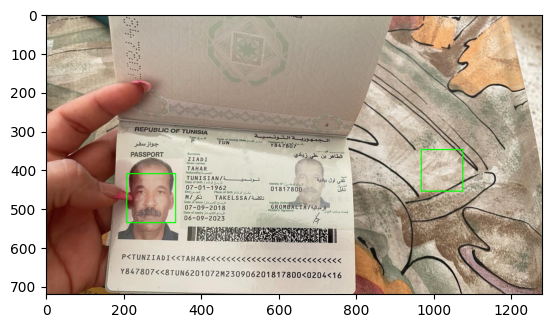

In [4]:
import cv2
import matplotlib.pyplot as plt

# Load your passport image
img = cv2.imread("passport_image.jpg")

checker = LayoutChecker()
result = await checker.check_passport_layout(img)
print(result)

# Visualize face detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 5)
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


In [5]:
import cv2
import numpy as np

class ImageDeskewer:
    @staticmethod
    def deskew(image: np.ndarray) -> np.ndarray:
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Invert & threshold
        gray = cv2.bitwise_not(gray)
        thresh = cv2.threshold(gray, 0, 255, 
                               cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

        # Get coordinates of all non-zero pixels
        coords = np.column_stack(np.where(thresh > 0))

        # Estimate angle of rotation
        angle = cv2.minAreaRect(coords)[-1]

        # Fix angle (OpenCV gives [-90, 0))
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle

        # Rotate the image to deskew
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h),
                                 flags=cv2.INTER_CUBIC, 
                                 borderMode=cv2.BORDER_REPLICATE)

        return rotated, angle


In [ ]:
image = cv2.imread("passport_rot1.jpg")
deskewer = ImageDeskewer()
rotated, angle = deskewer.deskew(image)

print(f"Rotated by {angle:.2f} degrees")
cv2.imshow("Deskewed Passport", rotated)
cv2.waitKey(0)
cv2.destroyAllWindows()



Rotated by -90.00 degrees


-1

In [7]:
import cv2
import numpy as np

class PassportAligner:
    def __init__(self):
        pass

    def straighten(self, image: np.ndarray) -> np.ndarray:
        """
        Automatically detects skew angle and rotates passport image.
        """
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)

        # Threshold for binary image
        thresh = cv2.threshold(gray, 0, 255,
                               cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

        # Detect coordinates of text
        coords = np.column_stack(np.where(thresh > 0))
        angle = cv2.minAreaRect(coords)[-1]

        # Fix angle range
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle

        # Rotate image
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h),
                                 flags=cv2.INTER_CUBIC,
                                 borderMode=cv2.BORDER_REPLICATE)

        print(f"[INFO] Rotation angle: {angle:.2f}")
        return rotated


In [11]:
image = cv2.imread("passport_rot1.jpg")
aligner = PassportAligner()
aligned_image = aligner.straighten(image)
print(aligned_image.shape)
cv2.imshow("Aligned Passport", aligned_image)
cv2.waitKey(0)
cv2.destroyAllWindows()



[INFO] Rotation angle: -90.00
(650, 450, 3)


In [15]:
import cv2
import numpy as np
import pytesseract

class PassportStraightener:
    @staticmethod
    def straighten(image: np.ndarray) -> np.ndarray:
        # Step 1: Deskew (small tilt)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        coords = np.column_stack(np.where(thresh > 0))
        angle = cv2.minAreaRect(coords)[-1]
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle
        (h, w) = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h),
                                 flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

        # Step 2: Detect orientation with Tesseract OSD
        osd = pytesseract.image_to_osd(rotated)
        rotation = int([s for s in osd.split() if s.isdigit()][0])  # extract rotation value
        if rotation != 0:
            rotated = cv2.rotate(rotated, {
                90: cv2.ROTATE_90_CLOCKWISE,
                180: cv2.ROTATE_180,
                270: cv2.ROTATE_90_COUNTERCLOCKWISE
            }[rotation])

        return rotated


image = cv2.imread("passport_rot2.jpg")
aligner = PassportAligner()
aligned_image = aligner.straighten(image)
print(aligned_image.shape)
cv2.imshow("Aligned Passport", aligned_image)
cv2.waitKey(0)
cv2.destroyAllWindows()



[INFO] Rotation angle: -0.00
(650, 450, 3)


In [16]:
import cv2
import numpy as np
from scipy import ndimage
import pytesseract
from PIL import Image, ImageEnhance
import math

class PassportRotationCorrector:
    """
    A comprehensive class to detect and correct rotation in passport images.
    Uses multiple methods for robust rotation detection and correction.
    """
    
    def __init__(self, debug=False):
        self.debug = debug
        
    def preprocess_image(self, image):
        """
        Preprocess the image for better rotation detection
        """
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
            
        # Enhance contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        
        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)
        
        return blurred
    
    def detect_rotation_hough_lines(self, image):
        """
        Detect rotation using Hough line detection on edges
        """
        preprocessed = self.preprocess_image(image)
        
        # Edge detection
        edges = cv2.Canny(preprocessed, 50, 150, apertureSize=3)
        
        # Hough line detection
        lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)
        
        if lines is None:
            return 0
        
        angles = []
        for rho, theta in lines[:, 0]:
            angle = math.degrees(theta) - 90
            # Normalize angle to -45 to 45 degrees
            if angle > 45:
                angle -= 90
            elif angle < -45:
                angle += 90
            angles.append(angle)
        
        if not angles:
            return 0
            
        # Use median angle to avoid outliers
        median_angle = np.median(angles)
        
        if self.debug:
            print(f"Hough lines detected angle: {median_angle:.2f}°")
            
        return median_angle
    
    def detect_rotation_contours(self, image):
        """
        Detect rotation using contour analysis (good for rectangular documents)
        """
        preprocessed = self.preprocess_image(image)
        
        # Threshold the image
        _, binary = cv2.threshold(preprocessed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return 0
            
        # Find the largest contour (should be the passport)
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get minimum area rectangle
        rect = cv2.minAreaRect(largest_contour)
        angle = rect[2]
        
        # Adjust angle based on rectangle orientation
        if rect[1][0] < rect[1][1]:  # width < height
            angle += 90
            
        # Normalize angle to -45 to 45 degrees
        if angle > 45:
            angle -= 90
        elif angle < -45:
            angle += 90
            
        if self.debug:
            print(f"Contour detected angle: {angle:.2f}°")
            
        return angle
    
    def detect_rotation_text_orientation(self, image):
        """
        Detect rotation using OCR text orientation detection
        """
        try:
            # Convert to PIL Image
            if isinstance(image, np.ndarray):
                pil_image = Image.fromarray(image)
            else:
                pil_image = image
                
            # Try different rotations and measure text confidence
            angles = [0, 90, 180, 270]
            max_confidence = 0
            best_angle = 0
            
            for angle in angles:
                rotated = pil_image.rotate(angle, expand=True)
                
                # Get OCR data with confidence scores
                try:
                    data = pytesseract.image_to_data(rotated, output_type=pytesseract.Output.DICT)
                    confidences = [int(conf) for conf in data['conf'] if int(conf) > 0]
                    
                    if confidences:
                        avg_confidence = np.mean(confidences)
                        if avg_confidence > max_confidence:
                            max_confidence = avg_confidence
                            best_angle = angle
                            
                except Exception:
                    continue
            
            # Convert to rotation needed (negative of detected rotation)
            rotation_needed = -best_angle if best_angle != 0 else 0
            
            if self.debug:
                print(f"OCR detected best orientation at {best_angle}°, rotation needed: {rotation_needed}°")
                
            return rotation_needed
            
        except Exception as e:
            if self.debug:
                print(f"OCR rotation detection failed: {e}")
            return 0
    
    def detect_rotation_projection_profile(self, image):
        """
        Detect rotation using projection profile analysis
        """
        preprocessed = self.preprocess_image(image)
        
        # Try different angles and find the one with maximum horizontal projection variance
        angles_to_test = np.arange(-45, 46, 1)  # Test angles from -45 to 45 degrees
        max_variance = 0
        best_angle = 0
        
        for angle in angles_to_test:
            # Rotate image
            rotated = ndimage.rotate(preprocessed, angle, reshape=False, cval=255)
            
            # Calculate horizontal projection (sum of pixels in each row)
            h_projection = np.sum(rotated, axis=1)
            
            # Calculate variance of projection
            variance = np.var(h_projection)
            
            if variance > max_variance:
                max_variance = variance
                best_angle = angle
        
        if self.debug:
            print(f"Projection profile detected angle: {best_angle:.2f}°")
            
        return best_angle
    
    def get_rotation_angle(self, image, methods=['all']):
        """
        Get rotation angle using multiple methods and return consensus
        """
        angles = []
        
        if 'all' in methods or 'hough' in methods:
            try:
                angle = self.detect_rotation_hough_lines(image)
                if abs(angle) > 0.5:  # Only consider significant angles
                    angles.append(angle)
            except Exception as e:
                if self.debug:
                    print(f"Hough lines method failed: {e}")
        
        if 'all' in methods or 'contours' in methods:
            try:
                angle = self.detect_rotation_contours(image)
                if abs(angle) > 0.5:  # Only consider significant angles
                    angles.append(angle)
            except Exception as e:
                if self.debug:
                    print(f"Contours method failed: {e}")
        
        if 'all' in methods or 'projection' in methods:
            try:
                angle = self.detect_rotation_projection_profile(image)
                if abs(angle) > 0.5:  # Only consider significant angles
                    angles.append(angle)
            except Exception as e:
                if self.debug:
                    print(f"Projection profile method failed: {e}")
        
        if 'all' in methods or 'ocr' in methods:
            try:
                angle = self.detect_rotation_text_orientation(image)
                if abs(angle) > 0.5:  # Only consider significant angles
                    angles.append(angle)
            except Exception as e:
                if self.debug:
                    print(f"OCR method failed: {e}")
        
        if not angles:
            if self.debug:
                print("No rotation detected by any method")
            return 0
        
        # Use median of detected angles for robustness
        final_angle = np.median(angles)
        
        if self.debug:
            print(f"All detected angles: {angles}")
            print(f"Final consensus angle: {final_angle:.2f}°")
        
        return final_angle
    
    def rotate_image(self, image, angle):
        """
        Rotate image by given angle
        """
        if abs(angle) < 0.1:  # No rotation needed
            return image
            
        if isinstance(image, np.ndarray):
            # For OpenCV/numpy arrays
            height, width = image.shape[:2]
            center = (width // 2, height // 2)
            
            # Get rotation matrix
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            
            # Calculate new dimensions
            cos = abs(rotation_matrix[0, 0])
            sin = abs(rotation_matrix[0, 1])
            new_width = int((height * sin) + (width * cos))
            new_height = int((height * cos) + (width * sin))
            
            # Adjust rotation matrix for new dimensions
            rotation_matrix[0, 2] += (new_width / 2) - center[0]
            rotation_matrix[1, 2] += (new_height / 2) - center[1]
            
            # Apply rotation
            rotated = cv2.warpAffine(image, rotation_matrix, (new_width, new_height), 
                                   flags=cv2.INTER_CUBIC, borderValue=(255, 255, 255))
            
        else:
            # For PIL Images
            rotated = image.rotate(-angle, expand=True, fillcolor='white')
        
        return rotated
    
    def correct_rotation(self, image, methods=['all'], confidence_threshold=0.5):
        """
        Main method to detect and correct rotation in passport image
        
        Args:
            image: Input image (numpy array or PIL Image)
            methods: List of methods to use ['hough', 'contours', 'projection', 'ocr', 'all']
            confidence_threshold: Minimum angle threshold to apply correction
            
        Returns:
            Corrected image and detected angle
        """
        if self.debug:
            print("Starting rotation correction...")
        
        # Detect rotation angle
        detected_angle = self.get_rotation_angle(image, methods)
        
        # Apply correction if angle is significant
        if abs(detected_angle) > confidence_threshold:
            corrected_image = self.rotate_image(image, -detected_angle)  # Negative to correct
            if self.debug:
                print(f"Applied rotation correction: {-detected_angle:.2f}°")
        else:
            corrected_image = image
            detected_angle = 0
            if self.debug:
                print("No significant rotation detected, image unchanged")
        
        return corrected_image, detected_angle
    
    def batch_correct_rotation(self, image_paths, output_dir=None, methods=['all']):
        """
        Correct rotation for multiple images
        """
        results = []
        
        for i, image_path in enumerate(image_paths):
            try:
                # Load image
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Could not load image: {image_path}")
                    continue
                
                # Correct rotation
                corrected_image, angle = self.correct_rotation(image, methods)
                
                # Save if output directory provided
                if output_dir:
                    import os
                    filename = os.path.basename(image_path)
                    name, ext = os.path.splitext(filename)
                    output_path = os.path.join(output_dir, f"{name}_corrected{ext}")
                    cv2.imwrite(output_path, corrected_image)
                
                results.append({
                    'input_path': image_path,
                    'output_path': output_path if output_dir else None,
                    'detected_angle': angle,
                    'corrected': abs(angle) > 0.5
                })
                
                if self.debug:
                    print(f"Processed {i+1}/{len(image_paths)}: {image_path}")
                    
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
                continue
        
        return results

# Example usage
if __name__ == "__main__":
    # Initialize corrector with debug mode
    corrector = PassportRotationCorrector(debug=True)
    
    # Example 1: Single image correction
    image = cv2.imread('passport_rot1.jpg.jpg')
    corrected_image, angle = corrector.correct_rotation(image)
    cv2.imwrite('corrected_passport.jpg', corrected_image)
    
    # Example 2: Using specific methods only
    # corrected_image, angle = corrector.correct_rotation(image, methods=['hough', 'contours'])
    
    # Example 3: Batch processing
    # image_paths = ['passport1.jpg', 'passport2.jpg', 'passport3.jpg']
    # results = corrector.batch_correct_rotation(image_paths, output_dir='corrected_images/')
    
    print("Passport Rotation Corrector class is ready to use!")
    print("\nKey methods:")
    print("- correct_rotation(image): Main correction method")
    print("- get_rotation_angle(image): Get detected rotation angle")
    print("- batch_correct_rotation(paths): Process multiple images")
    print("\nMethods available: 'hough', 'contours', 'projection', 'ocr', 'all'")

Starting rotation correction...
Hough lines method failed: 'NoneType' object has no attribute 'shape'
Contours method failed: 'NoneType' object has no attribute 'shape'
Projection profile method failed: 'NoneType' object has no attribute 'shape'
OCR rotation detection failed: 'NoneType' object has no attribute 'rotate'
No rotation detected by any method
No significant rotation detected, image unchanged


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:1146: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [21]:
import cv2
import numpy as np
from scipy import ndimage
import pytesseract
from PIL import Image, ImageEnhance
import math
import os 

class PassportRotationCorrector:
    """
    A comprehensive class to detect and correct rotation in passport images.
    Uses multiple methods for robust rotation detection and correction.
    """
    
    def __init__(self, debug=False):
        self.debug = debug
        
    def preprocess_image(self, image):
        """
        Preprocess the image for better rotation detection
        """
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
            
        # Enhance contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        
        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)
        
        return blurred
    
    def detect_rotation_hough_lines(self, image):
        """
        Detect rotation using Hough line detection on edges
        """
        preprocessed = self.preprocess_image(image)
        
        # Edge detection
        edges = cv2.Canny(preprocessed, 50, 150, apertureSize=3)
        
        # Hough line detection
        lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)
        
        if lines is None:
            return 0
        
        angles = []
        for rho, theta in lines[:, 0]:
            angle = math.degrees(theta) - 90
            # Normalize angle to -45 to 45 degrees
            if angle > 45:
                angle -= 90
            elif angle < -45:
                angle += 90
            angles.append(angle)
        
        if not angles:
            return 0
            
        # Use median angle to avoid outliers
        median_angle = np.median(angles)
        
        if self.debug:
            print(f"Hough lines detected angle: {median_angle:.2f}°")
            
        return median_angle
    
    def detect_rotation_contours(self, image):
        """
        Detect rotation using contour analysis (good for rectangular documents)
        """
        preprocessed = self.preprocess_image(image)
        
        # Threshold the image
        _, binary = cv2.threshold(preprocessed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return 0
            
        # Find the largest contour (should be the passport)
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get minimum area rectangle
        rect = cv2.minAreaRect(largest_contour)
        angle = rect[2]
        
        # Adjust angle based on rectangle orientation
        if rect[1][0] < rect[1][1]:  # width < height
            angle += 90
            
        # Normalize angle to -45 to 45 degrees
        if angle > 45:
            angle -= 90
        elif angle < -45:
            angle += 90
            
        if self.debug:
            print(f"Contour detected angle: {angle:.2f}°")
            
        return angle
    
    def detect_rotation_text_orientation(self, image):
        """
        Detect rotation using OCR text orientation detection
        """
        try:
            # Convert to PIL Image
            if isinstance(image, np.ndarray):
                pil_image = Image.fromarray(image)
            else:
                pil_image = image
                
            # Try different rotations and measure text confidence
            angles = [0, 90, 180, 270]
            max_confidence = 0
            best_angle = 0
            
            for angle in angles:
                rotated = pil_image.rotate(angle, expand=True)
                
                # Get OCR data with confidence scores
                try:
                    data = pytesseract.image_to_data(rotated, output_type=pytesseract.Output.DICT)
                    confidences = [int(conf) for conf in data['conf'] if int(conf) > 0]
                    
                    if confidences:
                        avg_confidence = np.mean(confidences)
                        if avg_confidence > max_confidence:
                            max_confidence = avg_confidence
                            best_angle = angle
                            
                except Exception:
                    continue
            
            # Convert to rotation needed (negative of detected rotation)
            rotation_needed = -best_angle if best_angle != 0 else 0
            
            if self.debug:
                print(f"OCR detected best orientation at {best_angle}°, rotation needed: {rotation_needed}°")
                
            return rotation_needed
            
        except Exception as e:
            if self.debug:
                print(f"OCR rotation detection failed: {e}")
            return 0
    
    def detect_rotation_projection_profile(self, image):
        """
        Detect rotation using projection profile analysis
        """
        preprocessed = self.preprocess_image(image)
        
        # Try different angles and find the one with maximum horizontal projection variance
        angles_to_test = np.arange(-45, 46, 1)  # Test angles from -45 to 45 degrees
        max_variance = 0
        best_angle = 0
        
        for angle in angles_to_test:
            # Rotate image
            rotated = ndimage.rotate(preprocessed, angle, reshape=False, cval=255)
            
            # Calculate horizontal projection (sum of pixels in each row)
            h_projection = np.sum(rotated, axis=1)
            
            # Calculate variance of projection
            variance = np.var(h_projection)
            
            if variance > max_variance:
                max_variance = variance
                best_angle = angle
        
        if self.debug:
            print(f"Projection profile detected angle: {best_angle:.2f}°")
            
        return best_angle
    
    def get_rotation_angle(self, image, methods=['all']):
        """
        Get rotation angle using multiple methods and return consensus
        """
        angles = []
        
        if 'all' in methods or 'hough' in methods:
            try:
                angle = self.detect_rotation_hough_lines(image)
                if abs(angle) > 0.5:  # Only consider significant angles
                    angles.append(angle)
            except Exception as e:
                if self.debug:
                    print(f"Hough lines method failed: {e}")
        
        if 'all' in methods or 'contours' in methods:
            try:
                angle = self.detect_rotation_contours(image)
                if abs(angle) > 0.5:  # Only consider significant angles
                    angles.append(angle)
            except Exception as e:
                if self.debug:
                    print(f"Contours method failed: {e}")
        
        if 'all' in methods or 'projection' in methods:
            try:
                angle = self.detect_rotation_projection_profile(image)
                if abs(angle) > 0.5:  # Only consider significant angles
                    angles.append(angle)
            except Exception as e:
                if self.debug:
                    print(f"Projection profile method failed: {e}")
        
        if 'all' in methods or 'ocr' in methods:
            try:
                angle = self.detect_rotation_text_orientation(image)
                if abs(angle) > 0.5:  # Only consider significant angles
                    angles.append(angle)
            except Exception as e:
                if self.debug:
                    print(f"OCR method failed: {e}")
        
        if not angles:
            if self.debug:
                print("No rotation detected by any method")
            return 0
        
        # Use median of detected angles for robustness
        final_angle = np.median(angles)
        
        if self.debug:
            print(f"All detected angles: {angles}")
            print(f"Final consensus angle: {final_angle:.2f}°")
        
        return final_angle
    
    def rotate_image(self, image, angle):
        """
        Rotate image by given angle
        """
        if image is None or (isinstance(image, np.ndarray) and image.size == 0):
            if self.debug:
                print("WARNING: Empty image provided to rotate_image")
            return image
            
        if abs(angle) < 0.1:  # No rotation needed
            return image
            
        try:
            if isinstance(image, np.ndarray):
                # For OpenCV/numpy arrays
                height, width = image.shape[:2]
                center = (width // 2, height // 2)
                
                # Get rotation matrix
                rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
                
                # Calculate new dimensions
                cos = abs(rotation_matrix[0, 0])
                sin = abs(rotation_matrix[0, 1])
                new_width = int((height * sin) + (width * cos))
                new_height = int((height * cos) + (width * sin))
                
                # Adjust rotation matrix for new dimensions
                rotation_matrix[0, 2] += (new_width / 2) - center[0]
                rotation_matrix[1, 2] += (new_height / 2) - center[1]
                
                # Apply rotation
                rotated = cv2.warpAffine(image, rotation_matrix, (new_width, new_height), 
                                       flags=cv2.INTER_CUBIC, borderValue=(255, 255, 255))
                
                # Verify rotation was successful
                if rotated is None or rotated.size == 0:
                    if self.debug:
                        print("WARNING: Rotation failed, returning original image")
                    return image
                    
            else:
                # For PIL Images
                rotated = image.rotate(-angle, expand=True, fillcolor='white')
                
                if rotated is None:
                    if self.debug:
                        print("WARNING: PIL rotation failed, returning original image")
                    return image
            
            return rotated
            
        except Exception as e:
            if self.debug:
                print(f"ERROR in rotate_image: {e}")
                print("Returning original image")
            return image
    
    def correct_rotation(self, image, methods=['all'], confidence_threshold=0.5):
        """
        Main method to detect and correct rotation in passport image
        
        Args:
            image: Input image (numpy array or PIL Image)
            methods: List of methods to use ['hough', 'contours', 'projection', 'ocr', 'all']
            confidence_threshold: Minimum angle threshold to apply correction
            
        Returns:
            Corrected image and detected angle
        """
        if self.debug:
            print("Starting rotation correction...")
        
        # Detect rotation angle
        detected_angle = self.get_rotation_angle(image, methods)
        
        # Apply correction if angle is significant
        if abs(detected_angle) > confidence_threshold:
            corrected_image = self.rotate_image(image, -detected_angle)  # Negative to correct
            if self.debug:
                print(f"Applied rotation correction: {-detected_angle:.2f}°")
        else:
            corrected_image = image
            detected_angle = 0
            if self.debug:
                print("No significant rotation detected, image unchanged")
        
        return corrected_image, detected_angle
    
    def batch_correct_rotation(self, image_paths, output_dir=None, methods=['all']):
        """
        Correct rotation for multiple images
        """
        results = []
        
        for i, image_path in enumerate(image_paths):
            try:
                # Load image
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Could not load image: {image_path}")
                    continue
                
                # Correct rotation
                corrected_image, angle = self.correct_rotation(image, methods)
                
                # Save if output directory provided
                if output_dir:
                    import os
                    filename = os.path.basename(image_path)
                    name, ext = os.path.splitext(filename)
                    output_path = os.path.join(output_dir, f"{name}_corrected{ext}")
                    cv2.imwrite(output_path, corrected_image)
                
                results.append({
                    'input_path': image_path,
                    'output_path': output_path if output_dir else None,
                    'detected_angle': angle,
                    'corrected': abs(angle) > 0.5
                })
                
                if self.debug:
                    print(f"Processed {i+1}/{len(image_paths)}: {image_path}")
                    
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
                continue
        
        return results


corrector = PassportRotationCorrector(debug=True)
    
# Example 1: Single image correction
image = cv2.imread('passport_rot2.jpg')
corrected_image, angle = corrector.correct_rotation(image)
cv2.imwrite('corrected_passport.jpg', corrected_image)
    

Starting rotation correction...
Hough lines detected angle: 1.00°
Contour detected angle: 0.00°
Projection profile detected angle: -45.00°
OCR detected best orientation at 0°, rotation needed: 0°
All detected angles: [np.float64(0.9999999922536347), np.int64(-45)]
Final consensus angle: -22.00°
Applied rotation correction: 22.00°


True

In [23]:
import cv2
import numpy as np
from scipy import ndimage
import pytesseract
from PIL import Image, ImageEnhance
import math
from skimage.feature import match_template
from skimage.transform import resize

class TemplateBasedPassportCorrector:
    """
    Advanced passport rotation corrector that uses template matching
    to find the correct orientation based on a reference passport structure.
    """
    
    def __init__(self, debug=False):
        self.debug = debug
        self.passport_template = None
        self.template_features = None
        
    def load_reference_template(self, template_path):
        """
        Load a reference passport image as template for comparison
        """
        template = cv2.imread(template_path)
        if template is None:
            raise ValueError(f"Could not load template from {template_path}")
            
        self.passport_template = template
        self.template_features = self._extract_template_features(template)
        
        if self.debug:
            print(f"Template loaded: {template.shape}")
            
    def create_generic_passport_template(self, width=600, height=400):
        """
        Create a generic passport template based on standard passport layout
        """
        template = np.ones((height, width, 3), dtype=np.uint8) * 255
        
        # Create typical passport regions
        # Photo region (left side)
        photo_region = (50, 50, 200, 250)  # x, y, width, height
        cv2.rectangle(template, (photo_region[0], photo_region[1]), 
                     (photo_region[0] + photo_region[2], photo_region[1] + photo_region[3]), 
                     (200, 200, 200), -1)
        
        # Text regions (right side)
        text_regions = [
            (300, 60, 250, 20),   # Name field
            (300, 100, 250, 20),  # Nationality
            (300, 140, 250, 20),  # Date of birth
            (300, 180, 150, 20),  # Passport number
            (300, 220, 150, 20),  # Issue date
            (300, 260, 150, 20),  # Expiry date
        ]
        
        for region in text_regions:
            cv2.rectangle(template, (region[0], region[1]), 
                         (region[0] + region[2], region[1] + region[3]), 
                         (150, 150, 150), -1)
        
        # Machine readable zone at bottom
        mrz_height = 60
        cv2.rectangle(template, (20, height - mrz_height - 20), 
                     (width - 20, height - 20), (100, 100, 100), -1)
        
        self.passport_template = template
        self.template_features = self._extract_template_features(template)
        
        if self.debug:
            print(f"Generic template created: {template.shape}")
            cv2.imwrite('debug_generic_template.jpg', template)
            
        return template
    
    def _extract_template_features(self, template):
        """
        Extract key features from template for matching
        """
        gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        
        # Extract edges
        edges = cv2.Canny(gray, 50, 150)
        
        # Extract corners
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, 
                                        qualityLevel=0.01, minDistance=10)
        
        # Calculate aspect ratio
        h, w = template.shape[:2]
        aspect_ratio = w / h
        
        # Extract horizontal and vertical projections
        h_projection = np.sum(gray, axis=1)
        v_projection = np.sum(gray, axis=0)
        
        return {
            'edges': edges,
            'corners': corners,
            'aspect_ratio': aspect_ratio,
            'h_projection': h_projection,
            'v_projection': v_projection,
            'shape': template.shape[:2]
        }
    
    def calculate_template_similarity(self, image, template):
        """
        Calculate similarity between image and template
        """
        # Resize image to match template
        template_h, template_w = template.shape[:2]
        image_resized = cv2.resize(image, (template_w, template_h))
        
        # Convert to grayscale
        if len(image_resized.shape) == 3:
            image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
        else:
            image_gray = image_resized
            
        if len(template.shape) == 3:
            template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        else:
            template_gray = template
        
        # Method 1: Template matching
        try:
            result = match_template(image_gray, template_gray)
            template_score = np.max(result)
        except:
            template_score = 0
        
        # Method 2: Edge similarity
        image_edges = cv2.Canny(image_gray, 50, 150)
        template_edges = cv2.Canny(template_gray, 50, 150)
        
        # Calculate edge intersection over union
        intersection = np.logical_and(image_edges, template_edges).sum()
        union = np.logical_or(image_edges, template_edges).sum()
        edge_iou = intersection / union if union > 0 else 0
        
        # Method 3: Structural similarity using projections
        img_h_proj = np.sum(image_gray, axis=1)
        img_v_proj = np.sum(image_gray, axis=0)
        
        template_h_proj = np.sum(template_gray, axis=1)
        template_v_proj = np.sum(template_gray, axis=0)
        
        # Normalize projections
        img_h_proj = img_h_proj / np.max(img_h_proj) if np.max(img_h_proj) > 0 else img_h_proj
        img_v_proj = img_v_proj / np.max(img_v_proj) if np.max(img_v_proj) > 0 else img_v_proj
        
        template_h_proj = template_h_proj / np.max(template_h_proj) if np.max(template_h_proj) > 0 else template_h_proj
        template_v_proj = template_v_proj / np.max(template_v_proj) if np.max(template_v_proj) > 0 else template_v_proj
        
        # Calculate correlation
        h_corr = np.corrcoef(img_h_proj, template_h_proj)[0, 1] if len(img_h_proj) == len(template_h_proj) else 0
        v_corr = np.corrcoef(img_v_proj, template_v_proj)[0, 1] if len(img_v_proj) == len(template_v_proj) else 0
        
        # Handle NaN values
        h_corr = h_corr if not np.isnan(h_corr) else 0
        v_corr = v_corr if not np.isnan(v_corr) else 0
        
        projection_score = (h_corr + v_corr) / 2
        
        # Combined similarity score
        combined_score = (template_score * 0.3 + edge_iou * 0.4 + projection_score * 0.3)
        
        if self.debug:
            print(f"Template score: {template_score:.3f}, Edge IoU: {edge_iou:.3f}, "
                  f"Projection score: {projection_score:.3f}, Combined: {combined_score:.3f}")
        
        return combined_score
    
    def find_best_rotation_template_matching(self, image):
        """
        Find the best rotation angle using template matching
        """
        if self.passport_template is None:
            # Create generic template if none provided
            self.create_generic_passport_template()
        
        # Test rotations at different angles
        test_angles = [0, 90, 180, 270]  # Primary rotations
        fine_angles = np.arange(-15, 16, 3)  # Fine-tuning around best match
        
        best_score = -1
        best_angle = 0
        best_rotation = None
        
        # First pass: test major rotations
        for angle in test_angles:
            if isinstance(image, np.ndarray):
                if angle == 0:
                    rotated = image.copy()
                else:
                    rotated = ndimage.rotate(image, angle, reshape=True, cval=255)
            else:
                rotated = image.rotate(angle, expand=True, fillcolor='white')
                rotated = np.array(rotated)
            
            score = self.calculate_template_similarity(rotated, self.passport_template)
            
            if score > best_score:
                best_score = score
                best_angle = angle
                best_rotation = rotated
        
        if self.debug:
            print(f"Best primary rotation: {best_angle}° with score: {best_score:.3f}")
        
        # Second pass: fine-tune around the best angle
        fine_best_score = best_score
        fine_best_angle = best_angle
        
        for fine_angle in fine_angles:
            test_angle = best_angle + fine_angle
            
            if isinstance(image, np.ndarray):
                rotated = ndimage.rotate(image, test_angle, reshape=True, cval=255)
            else:
                rotated = image.rotate(test_angle, expand=True, fillcolor='white')
                rotated = np.array(rotated)
            
            score = self.calculate_template_similarity(rotated, self.passport_template)
            
            if score > fine_best_score:
                fine_best_score = score
                fine_best_angle = test_angle
        
        if self.debug:
            print(f"Fine-tuned rotation: {fine_best_angle}° with score: {fine_best_score:.3f}")
        
        return fine_best_angle, fine_best_score
    
    def detect_rotation_aspect_ratio(self, image):
        """
        Detect rotation based on expected passport aspect ratio (typically ~1.4-1.5)
        """
        expected_ratio = 1.45  # Standard passport aspect ratio (width/height)
        tolerance = 0.3
        
        h, w = image.shape[:2]
        current_ratio = w / h
        
        # Test different rotations to find best aspect ratio match
        ratios = {
            0: current_ratio,
            90: h / w,
            180: current_ratio,
            270: h / w
        }
        
        best_angle = 0
        best_ratio_diff = float('inf')
        
        for angle, ratio in ratios.items():
            diff = abs(ratio - expected_ratio)
            if diff < best_ratio_diff:
                best_ratio_diff = diff
                best_angle = angle
        
        if self.debug:
            print(f"Aspect ratio analysis: current={current_ratio:.2f}, "
                  f"expected={expected_ratio:.2f}, best_angle={best_angle}°")
        
        # Only return angle if it's a significant improvement
        if best_ratio_diff < tolerance:
            return best_angle
        else:
            return 0
    
    def correct_rotation_with_template(self, image, template_path=None, methods=['template', 'aspect_ratio']):
        """
        Main method to correct rotation using template matching approach
        """
        if template_path:
            self.load_reference_template(template_path)
        elif self.passport_template is None:
            self.create_generic_passport_template()
        
        if self.debug:
            print("Starting template-based rotation correction...")
        
        rotation_candidates = []
        
        # Method 1: Template matching
        if 'template' in methods:
            try:
                angle, score = self.find_best_rotation_template_matching(image)
                if score > 0.3:  # Minimum confidence threshold
                    rotation_candidates.append(('template', angle, score))
                    if self.debug:
                        print(f"Template matching suggests: {angle}° (confidence: {score:.3f})")
            except Exception as e:
                if self.debug:
                    print(f"Template matching failed: {e}")
        
        # Method 2: Aspect ratio
        if 'aspect_ratio' in methods:
            try:
                angle = self.detect_rotation_aspect_ratio(image)
                if angle != 0:
                    rotation_candidates.append(('aspect_ratio', angle, 0.7))  # Fixed confidence
                    if self.debug:
                        print(f"Aspect ratio suggests: {angle}°")
            except Exception as e:
                if self.debug:
                    print(f"Aspect ratio method failed: {e}")
        
        # Select best rotation
        if not rotation_candidates:
            if self.debug:
                print("No rotation correction needed")
            return image, 0
        
        # Choose the candidate with highest confidence
        best_method, best_angle, best_confidence = max(rotation_candidates, key=lambda x: x[2])
        
        if self.debug:
            print(f"Selected rotation: {best_angle}° from {best_method} method")
        
        # Apply rotation
        if isinstance(image, np.ndarray):
            if best_angle != 0:
                corrected = ndimage.rotate(image, -best_angle, reshape=True, cval=255)
            else:
                corrected = image.copy()
        else:
            corrected = image.rotate(-best_angle, expand=True, fillcolor='white')
        
        return corrected, best_angle
    
    def save_debug_images(self, original, corrected, angle, prefix="debug"):
        """
        Save debug images for analysis
        """
        if self.debug:
            cv2.imwrite(f"{prefix}_original.jpg", original)
            cv2.imwrite(f"{prefix}_corrected.jpg", corrected)
            if self.passport_template is not None:
                cv2.imwrite(f"{prefix}_template.jpg", self.passport_template)
            print(f"Debug images saved with prefix '{prefix}'")

# Example usage combining both approaches
class HybridPassportCorrector:
    """
    Combines template-based and traditional methods for maximum accuracy
    """
    
    def __init__(self, debug=False):
        self.template_corrector = TemplateBasedPassportCorrector(debug=debug)
        self.debug = debug
    
    def correct_rotation(self, image, template_path=None):
        """
        Correct rotation using hybrid approach
        """
        if self.debug:
            print("=== HYBRID PASSPORT ROTATION CORRECTION ===")
        
        # Method 1: Template-based correction
        corrected_template, angle_template = self.template_corrector.correct_rotation_with_template(
            image, template_path, methods=['template', 'aspect_ratio']
        )
        
        if self.debug:
            print(f"Template-based result: {angle_template}°")
        
        # If template method found significant rotation, use it
        if abs(angle_template) > 5:
            return corrected_template, angle_template
        
        # Otherwise, use traditional methods as backup
        from PassportRotationCorrector import PassportRotationCorrector
        traditional_corrector = PassportRotationCorrector(debug=self.debug)
        corrected_traditional, angle_traditional = traditional_corrector.correct_rotation(image)
        
        if self.debug:
            print(f"Traditional method result: {angle_traditional}°")
        
        # Choose the method that detected more significant rotation
        if abs(angle_template) >= abs(angle_traditional):
            return corrected_template, angle_template
        else:
            return corrected_traditional, angle_traditional

# Example usage
if __name__ == "__main__":
    # Method 1: Using template-based corrector with reference image
    template_corrector = TemplateBasedPassportCorrector(debug=True)
    
    # Load your rotated passport
    image_path = 'passport_rot1.jpg'  # Your rotated passport
    template_path = 'templates/Australia Passport-1.jpg'  # Reference correct passport (optional)
    
    print(f"Loading image: {image_path}")
    image = cv2.imread(image_path)
    
    if image is not None:
        print(f"Image loaded: {image.shape}")
        
        # Option 1: Use with reference template
        if template_path and cv2.imread(template_path) is not None:
            corrected, angle = template_corrector.correct_rotation_with_template(image, template_path)
            print(f"Corrected using template reference. Angle: {angle}°")
        else:
            # Option 2: Use with generic passport template
            corrected, angle = template_corrector.correct_rotation_with_template(image)
            print(f"Corrected using generic template. Angle: {angle}°")
        
        # Save result
        if corrected is not None and corrected.size > 0:
            cv2.imwrite('template_corrected_passport.jpg', corrected)
            print("Template-corrected passport saved!")
            
            # Save debug images
            template_corrector.save_debug_images(image, corrected, angle, "template_debug")
        
    # Method 2: Using hybrid approach
    print("\n=== TRYING HYBRID APPROACH ===")
    hybrid_corrector = HybridPassportCorrector(debug=True)
    
    if image is not None:
        corrected_hybrid, angle_hybrid = hybrid_corrector.correct_rotation(image, template_path)
        cv2.imwrite('hybrid_corrected_passport.jpg', corrected_hybrid)
        print(f"Hybrid correction complete. Final angle: {angle_hybrid}°")

Loading image: passport_rot1.jpg
Image loaded: (650, 450, 3)
Template loaded: (1680, 1680, 3)
Starting template-based rotation correction...
Template score: 0.091, Edge IoU: 0.025, Projection score: 0.222, Combined: 0.104
Template score: 0.295, Edge IoU: 0.018, Projection score: 0.453, Combined: 0.232
Template score: 0.263, Edge IoU: 0.017, Projection score: 0.399, Combined: 0.206
Template score: 0.195, Edge IoU: 0.022, Projection score: 0.289, Combined: 0.154
Best primary rotation: 90° with score: 0.232
Template score: -0.364, Edge IoU: 0.018, Projection score: -0.588, Combined: -0.278
Template score: -0.334, Edge IoU: 0.018, Projection score: -0.526, Combined: -0.251
Template score: -0.291, Edge IoU: 0.018, Projection score: -0.456, Combined: -0.217
Template score: -0.217, Edge IoU: 0.017, Projection score: -0.354, Combined: -0.164
Template score: -0.046, Edge IoU: 0.018, Projection score: -0.109, Combined: -0.039
Template score: 0.295, Edge IoU: 0.018, Projection score: 0.453, Combi

In [2]:
# Install passporteye if not installed
# !pip install passporteye

from passporteye import read_mrz

def extract_mrz_data(image_path: str) -> dict:
    """
    Extracts MRZ data from a passport/ID image using PassportEye.

    Parameters
    ----------
    image_path : str
        Path to the passport image containing the MRZ.

    Returns
    -------
    dict
        Extracted MRZ fields (if detected), otherwise an error message.
    """
    # Read the MRZ from the image
    mrz = read_mrz(image_path)
    
    if mrz is None:
        return {"success": False, "message": "No MRZ found in the image."}
    
    # Convert result to dict
    mrz_data = mrz.to_dict()
    
    return {
        "success": True,
        "message": "MRZ successfully extracted.",
        "data": mrz_data
    }


result = extract_mrz_data("mrz.png")
print(result)


c:\CCC_data_factory\passport_min\venv\Lib\site-packages\passporteye\mrz\image.py:37: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  img = skimage_io.imread(file, as_gray=self.as_gray, plugin='imageio')
c:\CCC_data_factory\passport_min\venv\Lib\site-packages\passporteye\mrz\image.py:89: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  m = morphology.square(self.square_size)


{'success': False, 'message': 'No MRZ found in the image.'}


In [4]:
from passporteye.mrz.text import MRZ

def parse_mrz_from_lines(line1: str, line2: str) -> dict:
    """
    Parses MRZ data directly from two MRZ lines.

    Parameters
    ----------
    line1 : str
        First MRZ line.
    line2 : str
        Second MRZ line.

    Returns
    -------
    dict
        Parsed MRZ fields, regardless of validity.
    """
    # Parse MRZ
    mrz_obj = MRZ([line1, line2])
    
    if mrz_obj is None:
        return {
            "success": False,
            "message": "Could not parse MRZ at all.",
            "data": {"line1": line1, "line2": line2}
        }

    return {
        "success": mrz_obj.valid,   # True if all check digits valid
        "message": "MRZ parsed (valid)" if mrz_obj.valid else "MRZ parsed (invalid)",
        "data": mrz_obj.to_dict()
    }


line1 = "P<TUNZIEDI<<WISSAL<<<<<<<<<KKKKKKKKKKKKKKKKK"
line2 = "Y847835<<7TUN9O903218F230907309892239<0204<86"

result = parse_mrz_from_lines(line1, line2)
print(result)


{'success': False, 'message': 'MRZ parsed (invalid)', 'data': OrderedDict([('mrz_type', 'TD3'), ('valid_score', 24), ('type', 'P<'), ('country', 'TUN'), ('number', 'Y847835<<'), ('date_of_birth', '9O9032'), ('expiration_date', 'F23090'), ('nationality', 'TUN'), ('sex', '8'), ('names', 'WISSAL         KKKKKKKKKKKKKKKKK'), ('surname', 'ZIEDI'), ('personal_number', '309892239<0204'), ('check_number', '7'), ('check_date_of_birth', '1'), ('check_expiration_date', '7'), ('check_composite', '8'), ('check_personal_number', '<'), ('valid_number', True), ('valid_date_of_birth', False), ('valid_expiration_date', False), ('valid_composite', False), ('valid_personal_number', False)])}
